# Insert libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load dataset

In [2]:
def read_data(path):
    df = pd.read_csv(path)
    return df

data_path = 'creditcard.csv'
data = read_data(data_path)

In [3]:
import joblib

good_features = joblib.load('good_features.pkl')
bad_features = joblib.load('bad_features.pkl')

# Splitting the training and test datasets

In [4]:
# using stratified sampling instead of random sampling for the imbalanced dataset
from sklearn.model_selection import StratifiedShuffleSplit 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=11)

for train_index, test_index in split.split(data, data['Class']):    
    train_set = data.loc[train_index].reset_index(drop=True)    
    test_set = data.loc[test_index].reset_index(drop=True) 

In [5]:
train_counts = train_set.Class.value_counts()
ratio_train = round((train_counts[1]/train_counts.sum()*100), 3)

test_counts = test_set.Class.value_counts()
ratio_test = round((test_counts[1]/test_counts.sum()*100), 3)

print('Class ratio in the training set is {}'.format(ratio_train))
print('\nClass ratio in the test set is {}'.format(ratio_test))

Class ratio in the training set is 0.173

Class ratio in the test set is 0.172


# Feature scaling

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_set.iloc[:, :-1])
test_features = scaler.transform(test_set.iloc[:, :-1])

train_target = train_set.iloc[:, -1]
test_target = test_set.iloc[:, -1]

# Defining a function for:
- ### Building mutiple classification models
- ### Calculating different performance metrics of the models

In [7]:
def classification(models, X_Train, Y_Train, X_Test, Y_Test):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
                                
    accuracy = {}
    precision = {}
    recall = {}
    f1 = {}
    auc_roc = {}
    precision_recall = {}
    metrics = pd.DataFrame()
    for model_name, estimator in models.items():
        print('\nFitting {} model in progress...'.format(model_name))
        estimator.fit(X_Train, Y_Train)
        y_pred = estimator.predict(X_Test)
        y_predproba = estimator.predict_proba(X_Test)
        
        print('Calculating metrics for {} model...'.format(model_name))
        accuracy[model_name] = accuracy_score(Y_Test, y_pred)
        precision[model_name] = precision_score(Y_Test, y_pred)
        recall[model_name] = recall_score(Y_Test, y_pred)
        f1[model_name] = f1_score(Y_Test, y_pred)
        auc_roc[model_name] = roc_auc_score(Y_Test, y_predproba[:, 1])
        precision_recall[model_name] = average_precision_score(Y_Test, y_predproba[:, 1])
        
        new_metric = pd.DataFrame({'model': [model_name],
                                   'accuracy': [accuracy[model_name]],
                                   'precision': [precision[model_name]],
                                   'recall': [recall[model_name]],
                                   'f1': [f1[model_name]],
                                   'auc_roc': [auc_roc[model_name]],
                                   'precision_recall': precision_recall[model_name]})
        metrics = pd.concat([metrics, new_metric])
        
    return metrics

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
            'log': LogisticRegression(solver='lbfgs', random_state=5, n_jobs=-1),
            'knn': KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
            'random_forest': RandomForestClassifier(n_estimators=10, criterion='entropy',
                                                    max_depth=10, max_features=10, n_jobs=-1, random_state=5),
          }

# 1. Using original imbalanced dataset

In [9]:
# modeling - original data
original_metrics = classification(models, train_features, train_target, test_features, test_target)


Fitting log model in progress...
Calculating metrics for log model...

Fitting knn model in progress...
Calculating metrics for knn model...

Fitting random_forest model in progress...
Calculating metrics for random_forest model...


# 2. Applying oversampling technique

In [10]:
col_names = list(train_set.drop(columns=['Class']).columns)
train_features = pd.DataFrame(train_features, columns=col_names)
train_target = pd.DataFrame(train_target, columns=['Class'])

df_train = pd.concat([train_features, train_target], axis=1)

# separate minority and majority classes
legit = df_train[df_train.Class==0]
fraud = df_train[df_train.Class==1]

In [11]:
# oversample minority class
from sklearn.utils import resample
fraud_oversampled = resample(fraud,
                              replace=True, # sample with replacement
                              n_samples=len(legit), # match number in majority class
                              random_state=1)

# combine majority and upsampled minority classes
oversampled_data = pd.concat([legit, fraud_oversampled])

train_features_over = oversampled_data.drop('Class', axis=1).values
train_target_over = oversampled_data['Class'].values

# Build models with oversampled data
oversampled_metrics = classification(models, train_features_over, train_target_over, test_features, test_target)


Fitting log model in progress...
Calculating metrics for log model...

Fitting knn model in progress...
Calculating metrics for knn model...

Fitting random_forest model in progress...
Calculating metrics for random_forest model...


# 3. Applying undersampling technique

In [12]:
# Try undersampling method
legit_undersampled = resample(legit,
                                replace=False, # sample without replacement
                                n_samples=len(fraud), # match number in minority class
                                random_state=5)

# combine minority and undersampled majority
undersampled_data = pd.concat([legit_undersampled, fraud])

x_train_undersample = undersampled_data.drop('Class', axis=1).values
y_train_undersample = undersampled_data['Class'].values

# Build models with undersampled data
undersampled_metrics = classification(models, x_train_undersample, y_train_undersample, test_features, test_target)


Fitting log model in progress...
Calculating metrics for log model...

Fitting knn model in progress...
Calculating metrics for knn model...

Fitting random_forest model in progress...
Calculating metrics for random_forest model...


# 4. Using SMOTE method (oversampling)

In [13]:
# SMOTE method (oversampling)
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=5, sampling_strategy='minority')

train_features_sm, train_target_sm = sm.fit_sample(train_features, train_target)

# Build models with oversampled data
smote_metrics = classification(models, train_features_sm.values, train_target_sm.values.reshape(-1,), test_features, test_target)

Using TensorFlow backend.



Fitting log model in progress...
Calculating metrics for log model...

Fitting knn model in progress...
Calculating metrics for knn model...

Fitting random_forest model in progress...
Calculating metrics for random_forest model...


# 5. Using TomekLinks method (undersampling)

In [14]:
# TomekLinks method (undersampling)
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='auto', n_jobs=-1)
train_features_tl, train_target_tl = tl.fit_resample(train_features, train_target)

# Build models with undersampled data
tomek_metrics = classification(models, train_features_tl.values, train_target_tl.values.reshape(-1,), test_features, test_target)


Fitting log model in progress...
Calculating metrics for log model...

Fitting knn model in progress...
Calculating metrics for knn model...

Fitting random_forest model in progress...
Calculating metrics for random_forest model...


# Comparing all models
#### The results are sorted based on F1 score.Because it is the best metric (among the listed metrics) for evaluating classification models which have highly imbalanced distribution of classes.

In [15]:
# comparing different models
Metrics = pd.concat([original_metrics, oversampled_metrics, undersampled_metrics, smote_metrics, tomek_metrics])

In [16]:
n_models = 3
Metrics['method'] = ['original']*n_models + ['oversampled']*n_models + ['undersampled']*n_models + ['smote']*n_models + ['tomek']*n_models
Metrics.set_index('method').sort_values(by='precision_recall', ascending=False)

model  accuracy  precision    recall        f1  \
method                                                                 
oversampled   random_forest  0.999456   0.819048  0.877551  0.847291   
original      random_forest  0.999649   0.943182  0.846939  0.892473   
smote         random_forest  0.995102   0.245070  0.887755  0.384106   
original                knn  0.999719   0.955556  0.877551  0.914894   
tomek         random_forest  0.999719   0.976744  0.857143  0.913043   
tomek                   knn  0.999719   0.955556  0.877551  0.914894   
tomek                   log  0.999210   0.884058  0.622449  0.730539   
oversampled             knn  0.999315   0.761062  0.877551  0.815166   
original                log  0.999228   0.897059  0.622449  0.734940   
smote                   log  0.972824   0.055215  0.918367  0.104167   
oversampled             log  0.975317   0.061074  0.928571  0.114610   
undersampled            log  0.969910   0.050612  0.928571  0.095992   
smote                   knn  0.998648   0.569536  0.877551  0.690763   
undersampled  random_forest  0.968066   0.047819  0.928571  0.090955   
undersampled            knn  0.965486   0.044834  0.938776  0.085581   

               auc_roc  precision_recall  
method                                    
oversampled   0.974591          0.901898  
original      0.982209          0.878369  
smote         0.980270          0.870728  
original      0.943823          0.869280  
tomek         0.985224          0.868283  
tomek         0.943814          0.860707  
tomek         0.980209          0.789589  
oversampled   0.943751          0.788728  
original      0.979741          0.787980  
smote         0.988772          0.770590  
oversampled   0.987900          0.755177  
undersampled  0.986542          0.737857  
smote         0.943501          0.635486  
undersampled  0.987546          0.577111  
undersampled  0.985332          0.161685

# Result discussion
Final results showed that:
- RandomForest model with original dataset (without applying any oversampling or undersampling technique) provided the best performance for proper detection of two classes of transactions.
- Applying oversampling and undersampling methods, for classification problems with highly imbalanced samples, can adversely affect the model performance.

# Validation curve

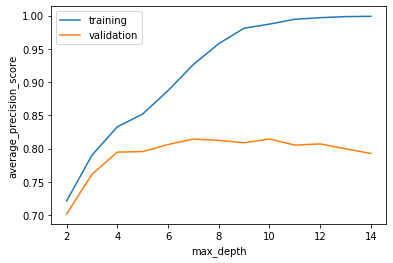

In [18]:
from sklearn.model_selection import validation_curve
model = RandomForestClassifier(n_estimators=10, criterion='entropy', max_features='auto', n_jobs=-1, random_state=5)

train_scores, valid_scores = validation_curve(model, 
                                             train_features, train_target, 
                                             param_name='max_depth',
                                             param_range=list(range(2, 15, 1)), 
                                             scoring='average_precision', 
                                             cv=3, n_jobs=-1)

plt.plot(list(range(2, 15, 1)), train_scores.mean(axis=1), label='training')
plt.plot(list(range(2, 15, 1)), valid_scores.mean(axis=1), label='validation')
plt.xlabel('max_depth')
plt.ylabel('average_precision_score')
plt.legend()
plt.show()

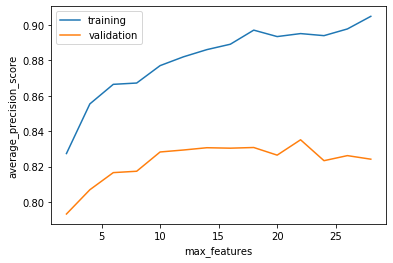

In [19]:
model = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=5, n_jobs=-1, random_state=5)

train_scores, valid_scores = validation_curve(model, 
                                             train_features, train_target, 
                                             param_name='max_features',
                                             param_range=list(range(2, 30, 2)), 
                                             scoring='average_precision', 
                                             cv=3, n_jobs=-1)

plt.plot(list(range(2, 30, 2)), train_scores.mean(axis=1), label='training')
plt.plot(list(range(2, 30, 2)), valid_scores.mean(axis=1), label='validation')
plt.xlabel('max_features')
plt.ylabel('average_precision_score')
plt.legend()
plt.show()

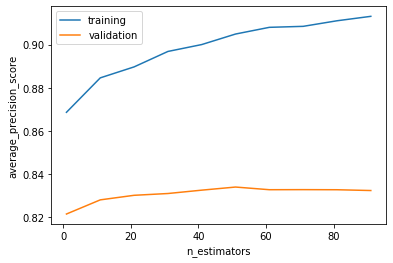

In [20]:
model = RandomForestClassifier(criterion='entropy', max_features=10, max_depth=5, n_jobs=-1, random_state=5)

train_scores, valid_scores = validation_curve(model, 
                                             train_features, train_target, 
                                             param_name='n_estimators',
                                             param_range=list(range(5, 100, 10)), 
                                             scoring='average_precision', 
                                             cv=3, n_jobs=-1)

plt.plot(list(range(1, 100, 10)), train_scores.mean(axis=1), label='training')
plt.plot(list(range(1, 100, 10)), valid_scores.mean(axis=1), label='validation')
plt.xlabel('n_estimators')
plt.ylabel('average_precision_score')
plt.legend()
plt.show()

# Optimizing hyperparameters

In [22]:
# random search over parameters
from sklearn.model_selection import RandomizedSearchCV

parameters = [{'n_estimators': np.arange(5, 30, 5),
               'max_depth': np.arange(2, 10, 1),
               'max_features': np.arange(2, 30, 2)}]

final_model = RandomForestClassifier()

grid_search = RandomizedSearchCV(estimator=final_model,
                                param_distributions=parameters,
                                n_iter=20,
                                scoring='average_precision',
                                n_jobs=-1,
                                refit=True,
                                cv=3,
                                random_state=5)

grid_search.fit(train_features, train_target.values.reshape(-1,))

print(grid_search.best_score_)
print(grid_search.best_params_)

0.8211413430107629
{'n_estimators': 20, 'max_features': 10, 'max_depth': 8}


In [23]:
feature_importances = grid_search.best_estimator_.feature_importances_ 
features = data.drop(columns='Class').columns
feature_importances = pd.DataFrame({'Feature':features, 'Importance':feature_importances})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
feature_importances.set_index('Feature', inplace=True, drop=True)
feature_importances.head(10)

Importance
Feature            
V17        0.225747
V14        0.156335
V10        0.149935
V16        0.107048
V12        0.103247
V11        0.038130
V26        0.020726
V6         0.018722
V7         0.017118
V9         0.015988

# Learning curve

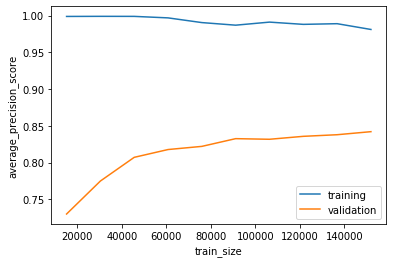

In [30]:
from sklearn.model_selection import learning_curve
model = RandomForestClassifier(n_estimators=20, criterion='entropy', max_features=10, max_depth=8, n_jobs=-1, random_state=5)

train_sizes, train_scores, valid_scores = learning_curve(model, 
                                                         train_features, train_target, 
                                                         train_sizes=np.linspace(0.1, 1, num=10), 
                                                         scoring='average_precision', 
                                                         cv=3, n_jobs=-1)

plt.plot(train_sizes, train_scores.mean(axis=1), label='training')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_size')
plt.ylabel('average_precision_score')
plt.legend()
plt.show()

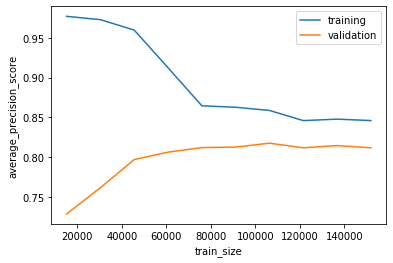

In [29]:
model = RandomForestClassifier(n_estimators=10, criterion='entropy', max_features=10, max_depth=4, n_jobs=-1, random_state=5)

train_sizes, train_scores, valid_scores = learning_curve(model, 
                                                         train_features, train_target, 
                                                         train_sizes=np.linspace(0.1, 1, num=10), 
                                                         scoring='average_precision', 
                                                         cv=3, n_jobs=-1)

plt.plot(train_sizes, train_scores.mean(axis=1), label='training')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_size')
plt.ylabel('average_precision_score')
plt.legend()
plt.show()

# Using a subset of important features

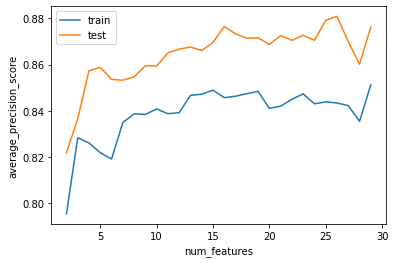

In [32]:
from sklearn.metrics import average_precision_score

scores = {}
for i in range(2, 30):
    best_features = feature_importances.index[:i]
    x_train = train_set[best_features].values
    x_test = test_set[best_features].values

    model = RandomForestClassifier(n_estimators=10, criterion='entropy', max_features=min(i, 10), max_depth=4,
                                   n_jobs=-1, random_state=5)
    model.fit(x_train, train_target.values.reshape(-1,))
    
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    predproba_train = model.predict_proba(x_train)
    predproba_test = model.predict_proba(x_test)
    train_score = average_precision_score(train_target, predproba_train[:, 1])
    test_score = average_precision_score(test_target, predproba_test[:, 1])
    scores[i] = [train_score, test_score]
    
pd.DataFrame.from_dict(scores, orient='index', columns=['train', 'test']).plot()
plt.xlabel('num_features')
plt.ylabel('average_precision_score')
plt.legend()
plt.show()

# Dimensionality reduction

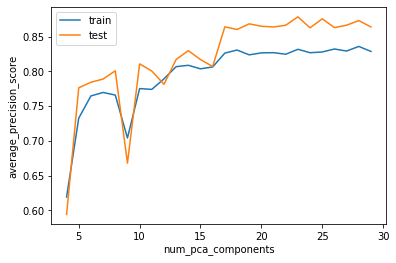

In [34]:
from sklearn.decomposition import PCA
scores = {}
for i in range(4, 30):
    pca = PCA(n_components=i)
    x_train = pca.fit_transform(train_features)
    x_test = pca.transform(test_features)

    model = RandomForestClassifier(n_estimators=10, criterion='entropy', max_features=min(i, 10), max_depth=4,
                                   n_jobs=-1, random_state=5)
    model.fit(x_train, train_target.values.reshape(-1,))
    
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    predproba_train = model.predict_proba(x_train)
    predproba_test = model.predict_proba(x_test)
    train_score = average_precision_score(train_target, predproba_train[:, 1])
    test_score = average_precision_score(test_target, predproba_test[:, 1])
    scores[i] = [train_score, test_score]
    
pd.DataFrame.from_dict(scores, orient='index', columns=['train', 'test']).plot()
plt.xlabel('num_pca_components')
plt.ylabel('average_precision_score')
plt.legend()
plt.show()

# Model validation

In [35]:
# k-fold cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold as skf

best_model = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=4, 
                                    max_features=10, n_jobs=-1, random_state=5)

scores = cross_val_score(estimator=best_model,
                        scoring='average_precision',
                        X=train_features, 
                        y=train_target.values.reshape(-1,),
                        cv=skf(n_splits=10))

print('mean score: %0.3f \nstd score: %0.3f' %(scores.mean(), scores.std()))

mean score: 0.821 
std score: 0.058


# Fitting the best model on the whole training set

In [47]:
best_model = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=4, 
                                    max_features=10, n_jobs=-1, random_state=5)

best_model.fit(train_features, train_target.values.reshape(-1,))
y_pred = best_model.predict(test_features)
y_predproba = best_model.predict_proba(test_features)

# Evaluating the best model on test set

In [48]:
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

In [49]:
print(classification_report(test_target, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.82      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



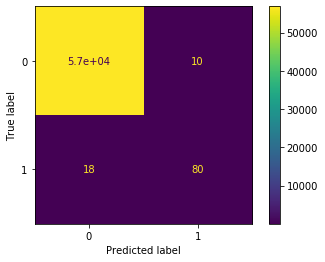

In [50]:
plot_confusion_matrix(best_model, test_features, test_target)

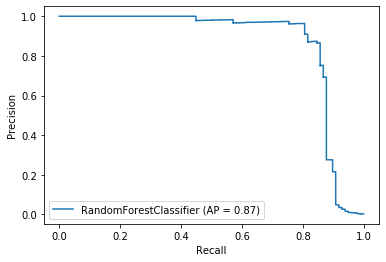

In [51]:
plot_precision_recall_curve(best_model, test_features, test_target)